# Проект: Канал в Телеграме с предсказаниями погоды в Москве.

Хочу создать небольшой канал/бот в Телеграме, в котором будет еженедельно или ежедневно поститься прогноз погоды от модели машинного обучения. Модель будет обучаться на наборе исторических данных за последние 5 или более лет.

Алгоритм действий:
- модель, раз в неделю/месяц получает свежие данные о погоде;
- обучается и проходит валидацию и тестирование;
- каждое воскресенье, присылает в канал прогноз погоды на следующую неделю если это еженедельный прогноз и каждый вечер присылает прогноз на следующий день, если ежедневный.

Задачи:
- Обработать данные о погоде, понять что в них представляет ценность.
- Понять, что и как можно автоматизировать при обработке новых данных.
- Задействовать Телеграм-бота для работы сервиса.
- Обучить и протестировать модель.
- Добиться хорошей точности прогноза.
- Сделать хороший вывод информации в Телеграм-канал.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Функции" data-toc-modified-id="Функции-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Функции</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Обработка-данных" data-toc-modified-id="Обработка-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обработка данных</a></span></li><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Разделение-на-выборки" data-toc-modified-id="Разделение-на-выборки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Разделение на выборки</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тест" data-toc-modified-id="Тест-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Тест</a></span></li><li><span><a href="#Внедрение" data-toc-modified-id="Внедрение-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Внедрение</a></span></li><li><span><a href="#Заключение" data-toc-modified-id="Заключение-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Заключение</a></span></li></ul></div>

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor
from notifiers import get_notifier

## Функции

In [2]:
def df_overview(df):
    '''
    Обзор датафрейма по ключевым моментам:
    таблица, случайная выборка, общая информация, количество пропусков, описание, корреляции.
    '''
    print('Dataframe overview:\n')
    display(df.head())
    print('--------------------------------------------\nSample:\n')
    display(df.sample(10, random_state=555))
    print('--------------------------------------------\nInfo:\n')
    print(df.info())
    print('--------------------------------------------\nNaN\'s:\n')
    print(df.isna().sum())
    print('--------------------------------------------\nDescribe:\n')
    display(df.describe())
    print('--------------------------------------------\nFeature correlation:\n')
    display(df.corr())

In [3]:
def new_time_features(df, key_column):
    '''
    Добавляет в таблицу признаки со смещением и со скользящей средней от ключевого столбца.
    '''
    
    df['month'] = df.index.month
    df['day'] = df.index.day

    df['rolling_mean'] = df[key_column].shift(7).rolling(7).mean()

    df['lag_7'] = df[key_column].shift(7)
    df['lag_15'] = df[key_column].shift(15)
    df['lag_30'] = df[key_column].shift(30)
    df['lag_90'] = df[key_column].shift(90)
    df['lag_180'] = df[key_column].shift(180)

    return df

In [4]:
def show_correlogram(df):
    '''
    Функция для построения визуализации по корреляции между признаками.
    '''
    plt.figure(figsize=(6,6), dpi= 80)
    sns.heatmap(
        df.corr(), xticklabels=df.corr().columns,
        yticklabels=df.corr().columns, cmap='RdYlGn', center=0, annot=True, cbar=False
    )
    plt.title('Correlogram between features', fontsize=16)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

In [5]:
def search_best_model(model, model_name, params, X, y):
    '''
    Функция по подбору лучшей модели с помощью GridSearchCV.
    '''
    print('<<<-------------------...Searching for best model...------------------->>>')
    clf = GridSearchCV(model, params, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)
    clf.fit(X, y)
    score = -1 * clf.best_score_
    print('------------------->>>Best model found successfully!<<<-------------------')
    print('\nBest {} MAE:'.format(model_name), score, '\nBest {} model:'.format(model_name), clf.best_estimator_)
    return score, clf.best_estimator_

In [6]:
def importances(model, model_name):
    '''
    Функция для визуализации наиболее важных признаков у выбранной модели.
    '''
    model.fit(X, y)
    result = permutation_importance(model, X, y, scoring='neg_mean_absolute_error', n_jobs=4, random_state=555)
    per_imp = pd.DataFrame(result.importances_mean, index=X.columns, columns=['permutation_importances'])
    
    per_imp.sort_values(by=['permutation_importances']).plot(
        kind='barh', title='Permutation importances {}'.format(model_name), figsize=(10, 8)
    )
    plt.show()
    return per_imp

In [7]:
def test_and_score(model):
    '''
    Функция по обучению модели на всей выборке и выводу оценки на тестовой выборке.
    '''
    model.fit(X, y)
    return mean_absolute_error(y_test, model.predict(X_test))

In [8]:
def make_predictions(df, model):
    '''
    Функция для создания таблицы с предсказаниями температуры с переименованными на русский днями недели
    '''
    df_pred = df.iloc[-7:]
    X_pred = df_pred.drop('temperature', axis=1)
    preds = best_cb_model.predict(X_pred)
    
    columns_to_drop = ['month', 'day', 'rolling_mean', 'lag_7',
                       'lag_15', 'lag_30', 'lag_90', 'lag_180']
    X_pred = X_pred.copy()
    X_pred['День недели'] = X_pred.index.day_name()
    X_pred['Температура'] = preds
    X_pred['Температура'] = X_pred['Температура'].round(1)
    X_pred = X_pred.drop(columns_to_drop, axis=1)
    
    days_week_rus = {
        'Monday':'Понедельник', 'Tuesday':'Вторник', 'Wednesday':'Среда',
        'Thursday':'Четверг', 'Friday':'Пятница',
        'Saturday':'Суббота', 'Sunday':'Воскресенье'
    }
    X_pred['День недели'] = X_pred['День недели'].replace(days_week_rus)
    
    return X_pred

In [9]:
def telegram_notifier_to_channel(
    token='<здесь указывается token бота в Телеграме>',
    chat_id='@<имя канала>'
):
    '''
    Функция для отправки сообщений ботом в канал Телеграм.
    '''
    def f(text):
        telegram = get_notifier('telegram')
        telegram.notify(
            message=text,
            token=token,
            chat_id=chat_id
        )
    return f

In [10]:
def telegram_notifier_to_bot(
    token='<здесь указывается token бота в Телеграме>',
    chat_id='<id чата в боте>'
):
    '''
    Функция для отправки сообщений в чат с ботом Телеграм.
    '''
    def f(text):
        telegram = get_notifier('telegram')
        telegram.notify(
            message=text,
            token=token,
            chat_id=chat_id
        )
    return f

## Загрузка данных

Данные загружены с сайта:
[rp5.ru](https://rp5.ru/Погода_в_мире)

In [11]:
new_columns = [
    'температура', 'температура2', 'атм_давл_на_ст', 'атм_давл_на_ур_мор', 'изм_атм_давл', 'отн_влаж',
    'напр_ветра', 'скор_ветра', 'макс_порыв_ветра1', 'макс_порыв_ветра2', 'облач', 'тек_погода',
    'прош_погода1', 'прош_погода2', 'мин_темп', 'макс_темп', 'облака', 'колич_обл', 'выс_обл',
    'облака1', 'облака2', 'дальн_вид', 'темп_точки_росы', 'колич_осадков', 'время_накопл_осадков',
    'поверхн_почвы', 'темп_почвы', 'поверхн_почвы2', 'выс_снега'
]
df = pd.read_csv(
    'Datasets/weather.csv', header=6, sep=';', index_col=[0],
    parse_dates=[0], names=new_columns, dayfirst=True
).sort_index(ascending=True)

In [12]:
df_overview(df)

Dataframe overview:



,температура,температура2,атм_давл_на_ст,атм_давл_на_ур_мор,изм_атм_давл,отн_влаж,напр_ветра,скор_ветра,макс_порыв_ветра1,макс_порыв_ветра2,...,облака1,облака2,дальн_вид,темп_точки_росы,колич_осадков,время_накопл_осадков,поверхн_почвы,темп_почвы,поверхн_почвы2,выс_снега
2015-01-01 00:00:00,-6.6,743.2,758.4,-0.7,93.0,"Ветер, дующий с западо-юго-запада",2,NaN,NaN,100%.,...,NaN,NaN,-7.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 01:00:00,-6.2,742.9,758.0,-0.7,92.0,"Ветер, дующий с западо-юго-запада",1,NaN,NaN,NaN,...,NaN,NaN,-7.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 02:00:00,-5.9,742.9,758.0,-0.5,93.0,"Ветер, дующий с запада",1,NaN,NaN,NaN,...,NaN,NaN,-6.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 03:00:00,-5.5,742.7,757.8,-0.5,92.0,"Ветер, дующий с запада",2,NaN,NaN,100%.,...,NaN,NaN,-6.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 04:00:00,-5.1,742.7,757.8,-0.2,94.0,"Ветер, дующий с запада",1,NaN,NaN,NaN,...,NaN,NaN,-5.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN


--------------------------------------------
Sample:



,температура,температура2,атм_давл_на_ст,атм_давл_на_ур_мор,изм_атм_давл,отн_влаж,напр_ветра,скор_ветра,макс_порыв_ветра1,макс_порыв_ветра2,...,облака1,облака2,дальн_вид,темп_точки_росы,колич_осадков,время_накопл_осадков,поверхн_почвы,темп_почвы,поверхн_почвы2,выс_снега
2021-03-20 15:00:00,0,746.8,761.7,-1.3,47.0,"Ветер, дующий с северо-запада",1,NaN,NaN,50%.,...,"Перистых, перисто-кучевых или перисто-слоистых...",10.0,-10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-08-19 12:00:00,25.4,751.3,764.9,-1.1,35.0,"Ветер, дующий с западо-юго-запада",1,NaN,NaN,Облаков нет.,...,NaN,10.0,8.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-22 12:00:00,20.3,742.8,756.5,-0.4,62.0,"Ветер, дующий с северо-северо-запада",1,NaN,NaN,"90 или более, но не 100%",...,"Перистых, перисто-кучевых или перисто-слоистых...",10.0,12.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-08-30 18:00:00,18.0,742.3,756.1,-0.8,92.0,"Штиль, безветрие",0,NaN,11.0,"90 или более, но не 100%",...,"Перистых, перисто-кучевых или перисто-слоистых...",4.0,16.6,2.0,12.0,NaN,NaN,NaN,NaN,NaN
2020-01-29 03:00:00,-1.4,742.6,757.5,-0.7,99.0,"Ветер, дующий с востоко-юго-востока",1,NaN,NaN,100%.,...,NaN,NaN,-1.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-01 21:00:00,3.3,743.0,757.6,1.3,95.0,"Штиль, безветрие",0,NaN,NaN,100%.,...,NaN,NaN,2.6,2.0,12.0,NaN,NaN,NaN,NaN,NaN
2015-05-01 04:00:00,9.7,751.7,766.1,0.1,44.0,"Ветер, дующий с востоко-северо-востока",2,NaN,NaN,NaN,...,NaN,NaN,-2.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-03 21:00:00,13.8,746.1,760.1,0.4,93.0,"Штиль, безветрие",0,NaN,NaN,70 – 80%.,...,"Перистых, перисто-кучевых или перисто-слоистых...",NaN,12.7,Осадков нет,12.0,NaN,NaN,NaN,NaN,NaN
2020-10-20 00:00:00,2.8,743.0,757.6,-0.8,80.0,"Ветер, дующий с юга",1,NaN,NaN,60%.,...,"Перистых, перисто-кучевых или перисто-слоистых...",NaN,-0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-29 03:00:00,20.9,745.1,758.8,-1.7,54.0,"Ветер, дующий с юго-юго-востока",1,NaN,NaN,100%.,...,NaN,NaN,11.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


--------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22531 entries, 2015-01-01 00:00:00 to 2021-09-03 12:00:00
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   температура           22530 non-null  object 
 1   температура2          22514 non-null  float64
 2   атм_давл_на_ст        22514 non-null  float64
 3   атм_давл_на_ур_мор    22305 non-null  float64
 4   изм_атм_давл          22514 non-null  float64
 5   отн_влаж              22531 non-null  object 
 6   напр_ветра            22531 non-null  int64  
 7   скор_ветра            113 non-null    float64
 8   макс_порыв_ветра1     840 non-null    float64
 9   макс_порыв_ветра2     21312 non-null  object 
 10  облач                 22531 non-null  object 
 11  тек_погода            9813 non-null   object 
 12  прош_погода1          9813 non-null   object 
 13  прош_погода2          4870 non-nul

,температура2,атм_давл_на_ст,атм_давл_на_ур_мор,изм_атм_давл,напр_ветра,скор_ветра,макс_порыв_ветра1,прош_погода2,мин_темп,облака2,дальн_вид,колич_осадков,поверхн_почвы,выс_снега
count,22514.000000,22514.000000,22305.000000,22514.000000,22531.000000,113.00000,840.000000,4870.000000,2434.000000,12655.000000,22515.000000,9702.000000,1388.000000,0.0
mean,747.303784,761.787528,0.000018,73.014746,1.146598,11.00000,11.359524,4.002012,10.841167,8.386416,1.892143,12.001237,9.896254,NaN
std,7.547203,7.777817,0.906104,19.548342,0.917038,1.36277,1.570521,9.007942,11.527609,2.830182,8.900973,0.121829,5.690596,NaN
min,718.200000,732.400000,-8.000000,12.000000,0.000000,10.00000,10.000000,-29.900000,-25.000000,0.200000,-33.300000,12.000000,-4.000000,NaN
25%,742.600000,756.900000,-0.500000,60.000000,1.000000,10.00000,10.000000,-1.800000,1.500000,4.000000,-4.100000,12.000000,6.000000,NaN
50%,747.300000,761.500000,0.000000,78.000000,1.000000,11.00000,11.000000,3.700000,10.200000,10.000000,1.100000,12.000000,11.000000,NaN
75%,751.900000,766.300000,0.500000,89.000000,2.000000,11.00000,12.000000,11.500000,21.300000,10.000000,9.400000,12.000000,14.000000,NaN
max,774.100000,789.100000,9.900000,100.000000,7.000000,18.00000,21.000000,21.900000,34.800000,50.000000,21.800000,24.000000,25.000000,NaN


--------------------------------------------
Feature correlation:



,температура2,атм_давл_на_ст,атм_давл_на_ур_мор,изм_атм_давл,напр_ветра,скор_ветра,макс_порыв_ветра1,прош_погода2,мин_темп,облака2,дальн_вид,колич_осадков,поверхн_почвы,выс_снега
температура2,1.000000,0.997298,0.059156,-0.188328,-0.108629,-0.069688,-0.015293,-0.142516,-0.079746,0.213287,-0.200767,-0.015122,-0.141533,NaN
атм_давл_на_ст,0.997298,1.000000,0.063223,-0.156381,-0.099988,-0.074085,-0.013089,-0.211429,-0.151500,0.191068,-0.263899,-0.015450,-0.188420,NaN
атм_давл_на_ур_мор,0.059156,0.063223,1.000000,0.091938,0.048163,0.076169,0.202845,0.022516,0.069291,0.004204,-0.025245,-0.029766,-0.058643,NaN
изм_атм_давл,-0.188328,-0.156381,0.091938,1.000000,-0.229131,0.025507,-0.055297,-0.194182,-0.356476,-0.645182,0.025988,0.011884,-0.003614,NaN
напр_ветра,-0.108629,-0.099988,0.048163,-0.229131,1.000000,0.405275,0.320425,-0.113820,-0.359850,0.125625,-0.225511,-0.000745,-0.132443,NaN
скор_ветра,-0.069688,-0.074085,0.076169,0.025507,0.405275,1.000000,0.527755,0.302328,0.125360,-0.231955,0.109710,NaN,NaN,NaN
макс_порыв_ветра1,-0.015293,-0.013089,0.202845,-0.055297,0.320425,0.527755,1.000000,-0.155362,0.039489,-0.015645,-0.059804,NaN,-0.223622,NaN
прош_погода2,-0.142516,-0.211429,0.022516,-0.194182,-0.113820,0.302328,-0.155362,1.000000,NaN,0.112852,0.965471,NaN,0.965200,NaN
мин_темп,-0.079746,-0.151500,0.069291,-0.356476,-0.359850,0.125360,0.039489,NaN,1.000000,0.127696,0.897304,NaN,NaN,NaN
облака2,0.213287,0.191068,0.004204,-0.645182,0.125625,-0.231955,-0.015645,0.112852,0.127696,1.000000,-0.017588,-0.018299,0.016445,NaN


## Обработка данных

Думаю, на начальном этапе, мне понадобится только колонока с температурой.

In [13]:
df = df['температура'].to_frame().astype('float')

In [14]:
df.head()

,температура
2015-01-01 00:00:00,-6.6
2015-01-01 01:00:00,-6.2
2015-01-01 02:00:00,-5.9
2015-01-01 03:00:00,-5.5
2015-01-01 04:00:00,-5.1


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22531 entries, 2015-01-01 00:00:00 to 2021-09-03 12:00:00
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   температура  22530 non-null  float64
dtypes: float64(1)
memory usage: 352.0 KB


In [16]:
df[df['температура'].isna()]

,температура
2020-07-11 09:00:00,NaN


In [17]:
df['2020-07-11':'2020-07-11']

,температура
2020-07-11 00:00:00,15.6
2020-07-11 03:00:00,16.8
2020-07-11 06:00:00,17.5
2020-07-11 09:00:00,NaN
2020-07-11 12:00:00,24.5
2020-07-11 15:00:00,27.5
2020-07-11 18:00:00,26.9
2020-07-11 21:00:00,24.3


Есть один пропуск, но так как будет ресемплирование, его в дальнейшем не будет.

<AxesSubplot:ylabel='Frequency'>

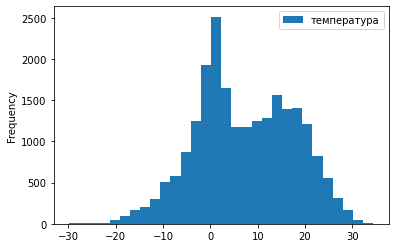

In [18]:
df.plot(kind='hist', bins=30)

Проверим на монотонность:

In [19]:
df.index.is_monotonic

True

Теперь, ресемплируем таблицу в однодневный формат:

In [20]:
df_daily = df.resample('1D').max()
df_daily

,температура
2015-01-01,0.8
2015-01-02,1.9
2015-01-03,2.6
2015-01-04,1.7
2015-01-05,-1.2
...,...
2021-08-30,22.8
2021-08-31,25.2
2021-09-01,19.9
2021-09-02,13.4


In [21]:
df_daily.isna().sum()

температура    0
dtype: int64

Теперь пропусков нет.

<AxesSubplot:ylabel='Frequency'>

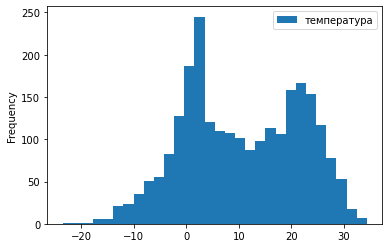

In [22]:
df_daily.plot(kind='hist', bins=30)

Есть два пика у распределения. Это связано со сменами сезонов. Посмотрим на них подробнее.

<AxesSubplot:title={'center':'trend'}>

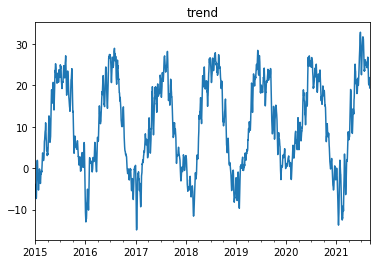

In [23]:
decomposed_daily = seasonal_decompose(df_daily)
decomposed_daily.trend.plot(title='trend')

Чётко видно смены трендов в зависамости от времени года.

<AxesSubplot:title={'center':'trend 2020'}>

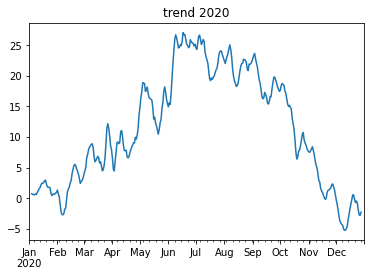

In [24]:
df_daily_2020 = df_daily['2020':'2020']
decomposed_daily_2020 = seasonal_decompose(df_daily_2020)
decomposed_daily_2020.trend.plot(title='trend 2020')

Посмотрим на сезонность по годам.

In [25]:
df_weekly = df.resample('1W').mean()
df_weekly

,температура
2015-01-04,0.315625
2015-01-11,-10.367066
2015-01-18,0.544311
2015-01-25,-6.159524
2015-02-01,-3.678571
...,...
2021-08-08,19.925000
2021-08-15,20.582143
2021-08-22,20.917857
2021-08-29,16.496429


<AxesSubplot:title={'center':'seasonal weekly'}>

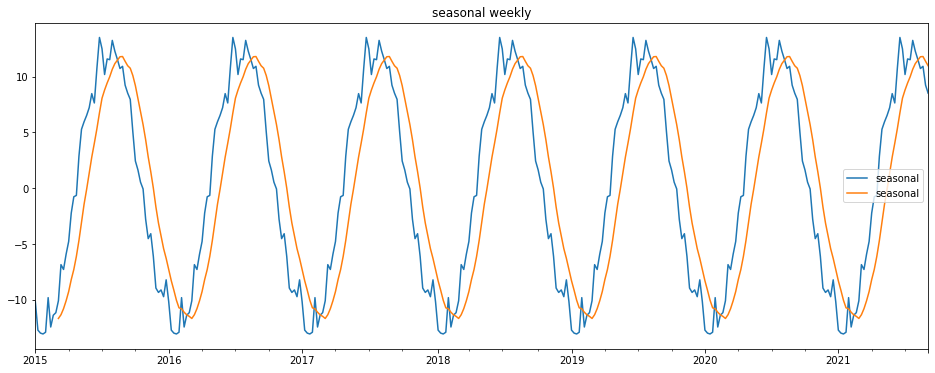

In [26]:
decomposed_weekly = seasonal_decompose(df_weekly)
decomposed_weekly.seasonal.plot(figsize=(16, 6), title='seasonal weekly', legend=True)
decomposed_weekly.seasonal.rolling(10).mean().plot(legend=True)

Эту сезонность можно использовать как фичи при обучении.

## Создание признаков

Итак, можно попробовать добавить фичи:
- месяц, неделя, день;
- скользящую среднюю с периодом: 10 дней;
- временные лаги: 7 дней, 15 дней, 30 дней, 90 дней, 180 дней.

Заодно переименуем колонку с температурой.

In [27]:
df_daily = df_daily.rename(columns={'температура':'temperature'})
df_daily.head()

,temperature
2015-01-01,0.8
2015-01-02,1.9
2015-01-03,2.6
2015-01-04,1.7
2015-01-05,-1.2


In [28]:
new_time_features(df_daily, 'temperature')

,temperature,month,day,rolling_mean,lag_7,lag_15,lag_30,lag_90,lag_180
2015-01-01,0.8,1,1,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,1.9,1,2,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-03,2.6,1,3,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-04,1.7,1,4,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,-1.2,1,5,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2021-08-30,22.8,8,30,24.271429,20.2,26.2,25.8,16.6,3.2
2021-08-31,25.2,8,31,22.728571,19.3,27.6,25.2,20.6,2.5
2021-09-01,19.9,9,1,21.100000,19.2,30.1,29.7,20.4,-1.7
2021-09-02,13.4,9,2,20.485714,19.3,30.6,22.8,22.9,-4.2


In [29]:
df_daily = df_daily.dropna()
df_daily.head()

,temperature,month,day,rolling_mean,lag_7,lag_15,lag_30,lag_90,lag_180
2015-06-30,21.6,6,30,21.571429,23.6,28.0,22.6,2.2,0.8
2015-07-01,25.1,7,1,22.514286,26.5,17.7,20.5,5.6,1.9
2015-07-02,26.0,7,2,23.200000,24.5,19.9,23.0,3.0,2.6
2015-07-03,22.0,7,3,23.742857,24.4,19.7,28.1,5.7,1.7
2015-07-04,29.2,7,4,23.500000,20.3,20.6,21.8,3.7,-1.2


Взглянем на корреляции:

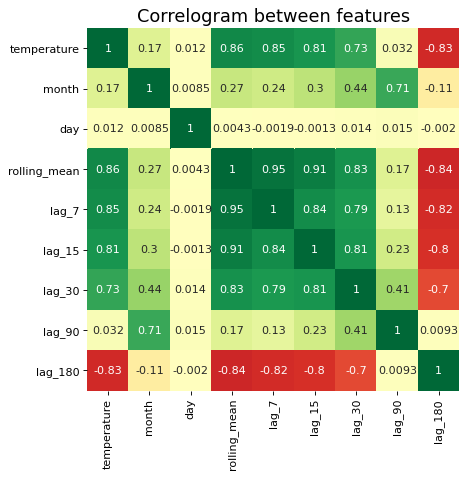

In [30]:
show_correlogram(df_daily)

Наблюдается высокая корреляция между целевым признаком, скользящим средним и лагами. Возможно это поможет обучению, а возможно модель будет переобучаться. Посмотрим. Ещё высокие корреляции между скользящим средним и небольшими лагами, они могут быть из-за того, что температура меняется не очень резко и все эти признаки имеют похожие изменения во времени. 

## Разделение на выборки

Теперь разделим на выборки.

In [31]:
X = df_daily.drop('temperature', axis=1)
y = df_daily['temperature']
print('Features: {}\nTarget: {}'.format(X.shape, y.shape))

Features: (2258, 8)
Target: (2258,)


Разделим на выборки в соотношении 90/5/5:

In [32]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.05, shuffle=False)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.055, shuffle=False)
print('Features', X_train.shape, X_valid.shape, X_test.shape, sep='  |  ')
print('Target ', y_train.shape, y_valid.shape, y_test.shape, sep='   |   ')
print('Ratio',
      round(len(X_train) / len(df_daily) * 100),
      round(len(X_valid) / len(df_daily) * 100),
      round(len(X_test) / len(df_daily) * 100), sep='     |     ')

Features  |  (2027, 8)  |  (118, 8)  |  (113, 8)
Target    |   (2027,)   |   (118,)   |   (113,)
Ratio     |     90     |     5     |     5


## Обучение

Обучим модель CatBoost и посмотрим на результаты и важные признаки.

In [33]:
best_cb_score, best_cb_model = search_best_model(
    model=CatBoostRegressor(),
    model_name='CatBoost',
    params={'iterations': range(1000, 3100, 100), 'verbose': [0],
            'random_state': [555], 'loss_function': ['MAE']},
    X=X, y=y
)

<<<-------------------...Searching for best model...------------------->>>
Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:  4.1min finished


------------------->>>Best model found successfully!<<<-------------------

Best CatBoost MAE: 4.112733919290439 
Best CatBoost model: <catboost.core.CatBoostRegressor object at 0x7f9b6895b2e0>


Результат вроде неплохой. Но есть ошибка четыре градуса.

Отправим сообщение в чат с ботом, что обучение прошло успешно:

In [34]:
send_bot = telegram_notifier_to_bot()

In [35]:
send_bot('Я обучился! Муррр!')

Посмотрим какие признаки были важными:

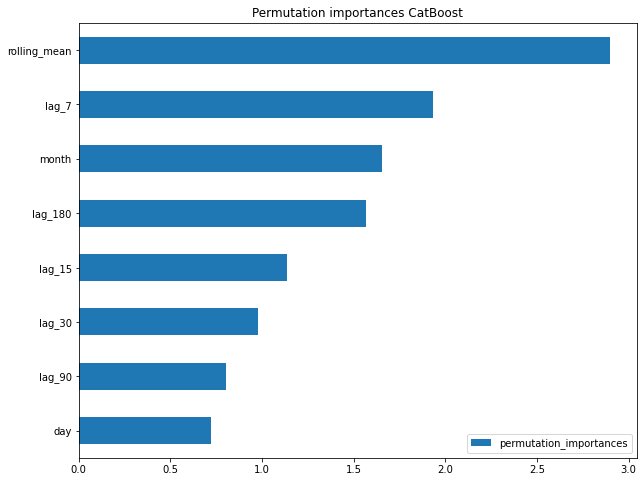

In [36]:
cb_importances = importances(best_cb_model, 'CatBoost')

Самой важной, оказалась скользящая средняя, остальные менее важны, но оставим все.

Теперь протестируем модель и проверим на адекватность предсказаний.

## Тест

In [37]:
display(
    pd.DataFrame(data=([best_cb_score, test_and_score(best_cb_model)],
                       ['--------', test_and_score(DummyRegressor())]),
                 columns=['Valid MAE', 'Test MAE'],
                 index=['CatBoost', 'Dummy'])
)

,Valid MAE,Test MAE
CatBoost,4.11273,4.316802
Dummy,--------,14.508187


Неплохой результат на тесте. И проверка на адекватность пройдена. И не наблюдается большого переобучения.

Отправим ещё одно сообщение в чат с ботом с результатами:

In [38]:
send_bot(
    'Мои успехи:\nValid MAE: {:.2f}\nTest MAE: {:.2f}'
    .format(best_cb_score, test_and_score(best_cb_model))
)

Получили в итоге два сообщения в нашем телеграм-боте:
![image](https://github.com/lobjob/weather_prediction_telegram_channel/blob/main/pics/bot_message.png)

Теперь надо внедрить нашу модель.

## Внедрение

Конечная цель: прогноз погоды на будущую неделю.

Значит нам надо обучить модель на всём датасете и добавить дополнительные семь дней в конце датасета, в которых она будет делать предсказания.

Плюс надо внедрить телеграм-бота который будет транслировать эти предсказания в телеграм-канал с погодой. Соответственно на выход, надо будет подавать переформатированную таблицу с последними 7-ю строками датасета, примерно в таком формате:

                                            Прогноз погоды на будущую неделю

|Дата      |День недели|Температура|
|:--------:|:---------:|:---------:|
|2021-09-01|Понедельник|19.0       |
|2021-09-02|Вторник    |18.5       |

... и так далее.

Сначала попробуем разобраться с данными: как присоединить будущую неделю, добавить признаки и потом подготовить данные к предсказанию, и конечному выводу.

Начнём с присоединения.

Сначала обучим нашу модель на всех данных, чтобы она делала более точный прогноз:

In [39]:
X = df_daily.drop('temperature', axis=1)
y = df_daily['temperature']
print('Features: {}\nTarget: {}'.format(X.shape, y.shape))

Features: (2258, 8)
Target: (2258,)


In [40]:
best_cb_model.fit(X, y)

Теперь, сделаем таблицу с дополнительными строками:

Последняя дата в таблице:

In [41]:
df_daily.index[-1]

Timestamp('2021-09-03 00:00:00', freq='D')

Сделаем список следующих 7-и дней:

In [42]:
next_7_dates = pd.Series(pd.date_range(df_daily.index[-1], periods=7, freq='D').shift().normalize())
next_7_dates

0   2021-09-04
1   2021-09-05
2   2021-09-06
3   2021-09-07
4   2021-09-08
5   2021-09-09
6   2021-09-10
dtype: datetime64[ns]

Создадим пустой датафрейм из этих дат:

In [43]:
df_daily_next = pd.DataFrame(index=next_7_dates, columns=df_daily.columns)
df_daily_next

,temperature,month,day,rolling_mean,lag_7,lag_15,lag_30,lag_90,lag_180
2021-09-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Соединим с основным датафреймом:

In [44]:
df_daily = pd.concat([df_daily, df_daily_next])
df_daily.tail(10)

,temperature,month,day,rolling_mean,lag_7,lag_15,lag_30,lag_90,lag_180
2021-09-01,19.9,9,1,21.100000,19.2,30.1,29.7,20.4,-1.7
2021-09-02,13.4,9,2,20.485714,19.3,30.6,22.8,22.9,-4.2
2021-09-03,10.4,9,3,20.071429,22.0,23.6,23.3,22.6,-2.0
2021-09-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Присоединили таблицы.

Теперь надо заполнить фичи, кроме целевого признака. По идее, все они должны заполниться, так как идут со смещением.

In [45]:
df_daily = new_time_features(df_daily, 'temperature')
df_daily.tail(10)

,temperature,month,day,rolling_mean,lag_7,lag_15,lag_30,lag_90,lag_180
2021-09-01,19.9,9,1,21.100000,19.2,30.1,29.7,20.4,-1.7
2021-09-02,13.4,9,2,20.485714,19.3,30.6,22.8,22.9,-4.2
2021-09-03,10.4,9,3,20.071429,22.0,23.6,23.3,22.6,-2.0
2021-09-04,NaN,9,4,20.085714,21.0,24.9,22.5,23.0,-4.9
2021-09-05,NaN,9,5,20.528571,22.7,20.9,28.0,20.8,-9.5
2021-09-06,NaN,9,6,20.900000,22.8,19.6,25.1,21.5,-12.5
2021-09-07,NaN,9,7,21.742857,25.2,20.2,23.3,19.0,-6.5
2021-09-08,NaN,9,8,21.842857,19.9,19.3,28.5,16.2,-5.1
2021-09-09,NaN,9,9,21.000000,13.4,19.2,28.1,17.4,-2.1
2021-09-10,NaN,9,10,19.342857,10.4,19.3,21.8,21.7,2.7


Получается, что мы можем нормально заполнить все лаги, но скользящую среднюю мы можем заполнить только на следующий день. Значит нам надо создать цикл из предсказаний, по одному дню. То есть, модель предсказывает на следующий день - заполняем следующее сначение скользящей средней, снова предсказываем один день - заполняем скользящую, и так до тех пор, пока не заполним все значения. Есть небольшая вероятность увеличения ошибки в концу недели, так как скользящая средняя будет уже брать значения предсказаний. Как вариант: увеличить диапазон скользящей средней, тогда предсказания будут меньше на неё влиять, но это может ухудшить качество модели, так как это самый важный признак. Надо будет поэкспериментировать.

Ещё вариант, сделать среднюю со смещением на 7 дней, возможно это провлияет на качество, но задо не надо будет заполнять пропуски, средняя не будет зависеть от предсказаний.

В итоге такой метод оказался довольно хорошим, метрики практически не снизились и таблица заполнена. Осталось сделать предсказания и вывести в таблицу нужного нам формата.

Попробуем сделать функцию, в которой будет формироваться таблица нужного нам формата и в которую будут вставляться предсказания (в блоке с функциями):

In [46]:
predictions_temperature = make_predictions(df_daily, best_cb_model)
predictions_temperature

,День недели,Температура
2021-09-04,Суббота,18.4
2021-09-05,Воскресенье,18.1
2021-09-06,Понедельник,19.1
2021-09-07,Вторник,20.8
2021-09-08,Среда,19.3
2021-09-09,Четверг,16.9
2021-09-10,Пятница,16.4


Получили таблицу нужного вида. Теперь надо сделать вывод таблицы в Телеграм.

Так как всю таблицу мы не можем отправить в виде сообщения (или я пока не знаю как это сделать), то выведем её в виде сообщения:

In [47]:
print('Предсказания на неделю:'
      '\nc {} по {}\n'
      '\nТемпература | День недели'
      '\n{}          {}'
      '\n{}          {}'
      '\n{}          {}'
      '\n{}          {}'
      '\n{}          {}'
      '\n{}          {}'
      '\n{}          {}'
      .format(predictions_temperature.index[0].date(),
              predictions_temperature.index[6].date(),
              predictions_temperature.iloc[0][1],
              predictions_temperature.iloc[0][0],
              predictions_temperature.iloc[1][1],
              predictions_temperature.iloc[1][0],
              predictions_temperature.iloc[2][1],
              predictions_temperature.iloc[2][0],
              predictions_temperature.iloc[3][1],
              predictions_temperature.iloc[3][0],
              predictions_temperature.iloc[4][1],
              predictions_temperature.iloc[4][0],
              predictions_temperature.iloc[5][1],
              predictions_temperature.iloc[5][0],
              predictions_temperature.iloc[6][1],
              predictions_temperature.iloc[6][0])
     )

Предсказания на неделю:
c 2021-09-04 по 2021-09-10

Температура | День недели
18.4          Суббота
18.1          Воскресенье
19.1          Понедельник
20.8          Вторник
19.3          Среда
16.9          Четверг
16.4          Пятница


Теперь отправим сообщение. Можно сделать два варианта: чтобы сообщение отправлялось только в чат с ботом, либо чтобы бот делал сразу пост на канале.

In [48]:
send_channel = telegram_notifier_to_channel()

In [49]:
predictions_text = ('Предсказания на неделю:'
                    '\nc "{}" по "{}"\n'
                    '\nТемпература | День недели'
                    '\n{}            {}'
                    '\n{}            {}'
                    '\n{}            {}'
                    '\n{}            {}'
                    '\n{}            {}'
                    '\n{}            {}'
                    '\n{}            {}'
                    .format(predictions_temperature.index[0].date(),
                            predictions_temperature.index[6].date(),
                            predictions_temperature.iloc[0][1],
                            predictions_temperature.iloc[0][0],
                            predictions_temperature.iloc[1][1],
                            predictions_temperature.iloc[1][0],
                            predictions_temperature.iloc[2][1],
                            predictions_temperature.iloc[2][0],
                            predictions_temperature.iloc[3][1],
                            predictions_temperature.iloc[3][0],
                            predictions_temperature.iloc[4][1],
                            predictions_temperature.iloc[4][0],
                            predictions_temperature.iloc[5][1],
                            predictions_temperature.iloc[5][0],
                            predictions_temperature.iloc[6][1],
                            predictions_temperature.iloc[6][0])
                   )

In [50]:
#send_bot(predictions_text)
send_channel(predictions_text)

Получили сообщение с прогнозом в телеграм-канале:
![image2](https://github.com/lobjob/weather_prediction_telegram_channel/blob/main/pics/channel_message.png)

## Заключение

Получился небольшой канал-сервис в Телеграме по предсказанию погоды в Москве на будущую неделю.

В планах:
- добавить предсказания минимальной температуры;
- улучшить качество предсказаний путём добавления фичей:
  - среднее суточное давление воздуха;
  - средняя суточная относительная влажность;
  - средняя суточная скорость ветра;
  - средняя суточная температура точки росы;
- автоматизировать сбор данных по температуре;
- автоматизировать процесс выполнения предсказания.

Спасибо за внимание!